In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import sys; sys.path.append('.')

env: CUDA_VISIBLE_DEVICES=0


In [2]:
#TMP - rm when format gets fixed
_='\n'.join(filter(len, open("./data/bpe_parallel2.txt").read().split('\n')))
open("./data/bpe_parallel2.txt", 'w').write(_)

5453204

In [3]:
import numpy as np
from vocab import Vocab
inp_voc = Vocab.from_file("./data/1.voc")
out_voc = Vocab.from_file("./data/2.voc")

In [4]:
import tensorflow as tf
from models.transformer_other import Model 
from lib.tensor_utils import infer_length, infer_mask


In [5]:

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.95
sess = tf.InteractiveSession(config=config)


mini_hp = {
        'hid_size': 256,
        'ff_size': 1024,
        'num_heads': 4,
        'num_layers': 2,
    
        'rescale_emb': True,
        'relu_dropout': 0.,
        'res_dropout': 0.,
        'attn_dropout': 0.,
        'inp_emb_bias': True,
        'res_steps': 'nlda',
        'normalize_out': True,
        'force_bos': True,
        'dwwt':True
}

model = Model('mod',inp_voc,out_voc,**mini_hp)

In [6]:
from itertools import islice, chain
class train:
    
    def iterate_lines(batch_size=16, batches_per_epoch=None, skip_lines=0,
                      src_path = "./data/bpe_parallel1.txt",
                      dst_path = "./data/bpe_parallel2.txt",
                      ):
        while True:
            with open(src_path) as f_src, open(dst_path) as f_dst:
                
                num_lines = batches_per_epoch * batch_size if batches_per_epoch is not None else None
                
                f_src = islice(f_src, skip_lines, num_lines)
                f_dst = islice(f_dst, skip_lines, num_lines)

                batch = []
                for src_line, dst_line in zip(f_src, f_dst):
                    if len(src_line) ==0 or len(dst_line)==0: continue
                    
                    batch.append([src_line[:-1], dst_line[:-1]])
                    if len(batch) >= batch_size:
                        yield (batch)
                        batch = []
                
                if batches_per_epoch is not None:
                    raise StopIteration()        
    
class dev:
    dev_src = "./data/bpe_parallel1.txt"
    dev_dst = "./data/bpe_parallel2.txt"

    inp_lines = np.array(open(dev_src).read()[:-1].split('\n'))
    out_lines = np.array(open(dev_dst).read()[:-1].split('\n'))

In [7]:
from bleu import compute_bleu

In [8]:
inp = tf.placeholder("int32", [None,None], name="inp")
out = tf.placeholder("int32", [None,None], name="out")

In [9]:
logits = model.symbolic_score(inp, out, is_train=True) [:, :tf.shape(out)[1]]
# logits are already alligned with out

In [10]:
from lib.tensor_utils import infer_mask, initialize_uninitialized_variables

nll = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=out)

loss = nll * infer_mask(out, out_voc.eos, dtype=tf.float32)

loss = tf.reduce_sum(loss, axis=1)
loss = tf.reduce_mean(loss)

In [11]:
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, model.name)
grads = tf.gradients(loss, weights)
grads = tf.clip_by_global_norm(grads, 100)[0]
train_step = tf.train.AdamOptimizer(learning_rate=1e-4, beta2=0.98).apply_gradients(zip(grads,weights))

In [12]:
translation = model.symbolic_translate(inp, mode='sample', max_len=100)

In [13]:
pred = translation.best_out

In [14]:
initialize_uninitialized_variables(sess)

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import count
from pandas import ewma
from tqdm import tqdm
from time import sleep
epoch = 0
loss_history = []
bleu_history = []

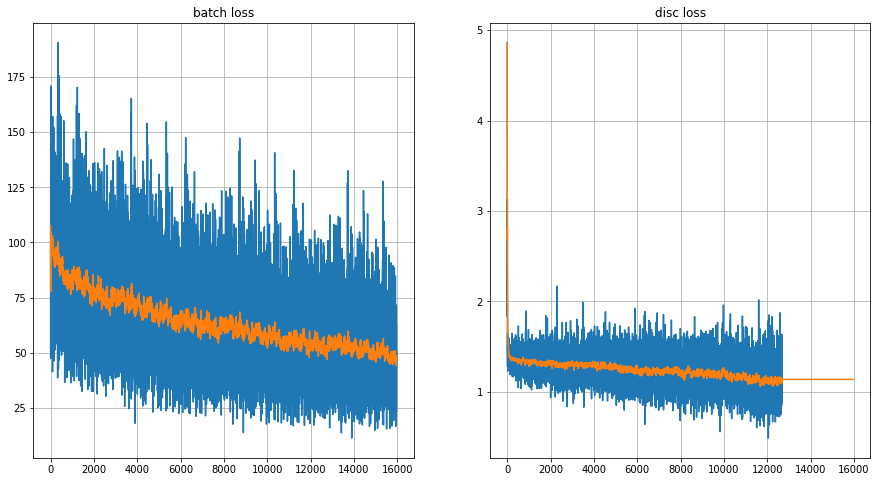

15962it [1:16:39,  3.47it/s]


KeyboardInterrupt: 

In [39]:
batch_size = 10
for i, batch in enumerate(tqdm(train.iterate_lines(batch_size, batches_per_epoch=None))):
    batch_src, batch_dst = zip(*batch)
    batch_src_ix = inp_voc.tokenize_many(batch_src)
    batch_dst_ix = out_voc.tokenize_many(batch_dst)
    
    feed_dict = {inp: batch_src_ix, out: batch_dst_ix}
    
    loss_t = sess.run([train_step, loss], feed_dict)[1]
    
    loss_history.append(np.mean(loss_t))
        
    if (epoch+1) % 500 == 0:
        #test_bleu_history.append([epoch,compute_bleu(model, dev.inp_lines[::5], dev.out_lines[::5])[0]])
        
        
        w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="{0}/".format(model.name))
        w_values = sess.run(w_variables)
        weights_dict = {w.name: w_val for w, w_val in zip(w_variables,w_values)}
        np.savez("./mimic-model-%i.npz"%epoch, **weights_dict)
        
        d_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="{0}/".format(discriminator.name))
        d_values = sess.run(d_variables)
        disc_weights_dict = {d.name: d_val for d, d_val in zip(d_variables,d_values)}
        np.savez("./mimic-disc-%i.npz"%epoch, **disc_weights_dict)
        
    
    if epoch % 10 == 0:
        clear_output(True)
        plt.figure(figsize=[15,8])
        plt.subplot(121)
        plt.title("batch loss")
        plt.plot(loss_history)
        plt.plot(ewma(np.array(loss_history),span=50))
        plt.grid()
        plt.subplot(122)
        plt.title("disc loss")
        plt.plot(disc_loss_history)
        plt.plot(ewma(np.array(disc_loss_history),span=50))
        plt.grid()
        plt.show()
    epoch +=1
        

In [19]:
w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="{0}/".format(model.name))
weights_dict = {w.name: w for w in w_variables}
with np.load("./mimic-model-8499.npz") as file:
    for key in file:
        value = file[key]
        sess.run([tf.assign(weights_dict[key],value )])


d_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="{0}/".format(discriminator.name))
disc_weights_dict = {d.name: d for d in d_variables}
with np.load("./mimic-disc-8499.npz") as file:
    for key in file:
        value = file[key]
        sess.run([tf.assign(disc_weights_dict[key],value )])

In [40]:
inp_voc.detokenize_many(batch_src_ix, unbpe=True, deprocess=True)

['The kitchenette comes with a fridge , electric kettle and kitchen utensils .',
 'With vaulted ceilings , each room at B &amp; B Ghalà will provide you with a desk and a safe .',
 'Louvre Museum is 800 metres from Welcome Hotel , while Notre Dame Cathedral is 900 metres away .',
 'The property features a garden with BBQ facilities and free WiFi in public areas .',
 'The nearest airport is Anapa Airport , 13 km from the property .',
 'The Sheraton is within easy walking distance to shops , outdoor cafés and cultural attractions of Zagreb .',
 'Free local calls are included .',
 'Towels are featured .',
 'This bed and breakfast has water sports facilities and free use of bicycles is available .',
 'Visitors can also discover the nearby towns of Waiblingen and Ludwigsburg .']

In [41]:
out_voc.detokenize_many(sess.run(pred,feed_dict= {inp: batch_src_ix}) , unbpe=True, deprocess=True)

['В апартаментах есть мини-кухня с холодильником , электрическим чайником и Дубровника .',
 'Во всех бесплатный Wi-Fi фунтов Парно двухвребеседкой тренажерном зале , мотеля есть письменный стол и сейф .',
 "В 800 метрах от отеля полностью house Real находится Музей вский `` Южный Моставить на ,'' а в 900 метрах - телевизору .",
 'Гостям предлагается размещение в саду с принадлежностями для барбекю и бесплатный Wi-Fi в местах общественного пользования .',
 'Расстояние до аэропорта шумит Велиндбезопасное на составляет 13 км .',
 'гранполулюкс Hкигровая площадка , открытый кафе и герской кухни .',
 'фумигабесплатное посудомоечной машиной .',
 'Предоставляются полотенца .',
 'Гостям предоставляется бесплатный прокат велосипедов и бесплатные ГолуМоломассажиигровая серных .',
 'Листа , интерьер этого Villa Bad Trav-Garden , предупредить изучать И Рямбруфен .']